## Image segmentation with CamVid

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [3]:
path = untar_data(URLs.CAMVID)
path.ls()

[PosixPath('/home/jupyter/.fastai/data/camvid/codes.txt'),
 PosixPath('/home/jupyter/.fastai/data/camvid/images'),
 PosixPath('/home/jupyter/.fastai/data/camvid/labels'),
 PosixPath('/home/jupyter/.fastai/data/camvid/valid.txt')]

In [4]:
path_lbl = path/'labels'
path_img = path/'images'

## Subset classes

In [ ]:
# path = Path('./data/camvid-small')

# def get_y_fn(x): return Path(str(x.parent)+'annot')/x.name

# codes = array(['Sky', 'Building', 'Pole', 'Road', 'Sidewalk', 'Tree',
#     'Sign', 'Fence', 'Car', 'Pedestrian', 'Cyclist', 'Void'])

# src = (SegmentationItemList.from_folder(path)
#        .split_by_folder(valid='val')
#        .label_from_func(get_y_fn, classes=codes))

# bs=8
# data = (src.transform(get_transforms(), tfm_y=True)
#         .databunch(bs=bs)
#         .normalize(imagenet_stats))

## Data

In [6]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/home/jupyter/.fastai/data/camvid/images/Seq05VD_f03930.png'),
 PosixPath('/home/jupyter/.fastai/data/camvid/images/0016E5_00960.png'),
 PosixPath('/home/jupyter/.fastai/data/camvid/images/0001TP_008430.png')]

In [5]:
doc(get_image_files)

In [7]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('/home/jupyter/.fastai/data/camvid/labels/Seq05VD_f00240_P.png'),
 PosixPath('/home/jupyter/.fastai/data/camvid/labels/Seq05VD_f02160_P.png'),
 PosixPath('/home/jupyter/.fastai/data/camvid/labels/0001TP_009930_P.png')]

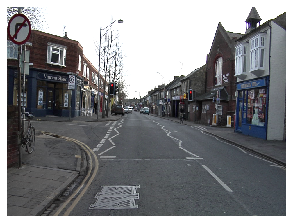

In [26]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [27]:
img.shape

torch.Size([3, 720, 960])

In [10]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

In [18]:
path_lbl, img_f, img_f.stem, img_f.suffix

(PosixPath('/home/jupyter/.fastai/data/camvid/labels'),
 PosixPath('/home/jupyter/.fastai/data/camvid/images/Seq05VD_f03930.png'),
 'Seq05VD_f03930',
 '.png')

In [13]:
get_y_fn(img_f)

PosixPath('/home/jupyter/.fastai/data/camvid/labels/Seq05VD_f03930_P.png')

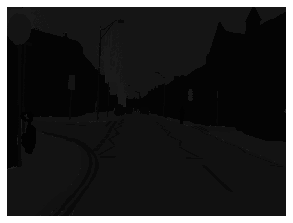

In [21]:
img = open_image(get_y_fn(img_f))
img.show(figsize=(5,5))

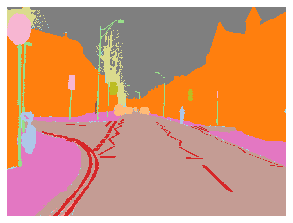

In [23]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [8]:
doc(open_mask)

In [24]:
doc(mask.show)

In [29]:
mask.shape, mask.shape[1]

(torch.Size([1, 720, 960]), 720)

In [30]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([720, 960]), tensor([[[21, 21, 21,  ..., 21, 21, 21],
          [21, 21, 21,  ..., 21, 21, 21],
          [21, 21, 21,  ..., 21, 21, 21],
          ...,
          [19, 19, 19,  ..., 17, 17, 17],
          [19, 19, 19,  ..., 17, 17, 17],
          [19, 19, 19,  ..., 17, 17, 17]]]))

In [36]:
codes = np.loadtxt(path/'codes.txt', dtype=str); codes, codes.size

(array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
        'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
        'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
        'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17'),
 32)

## Datasets

In [37]:
size = src_size//2

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=8
else:           bs=4
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=4, have 7601MB of GPU RAM free


In [40]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_y_fn, classes=codes))

In [38]:
doc(SegmentationItemList.from_folder)

In [43]:
type(src)

fastai.data_block.LabelLists

In [45]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [44]:
doc(src.transform)

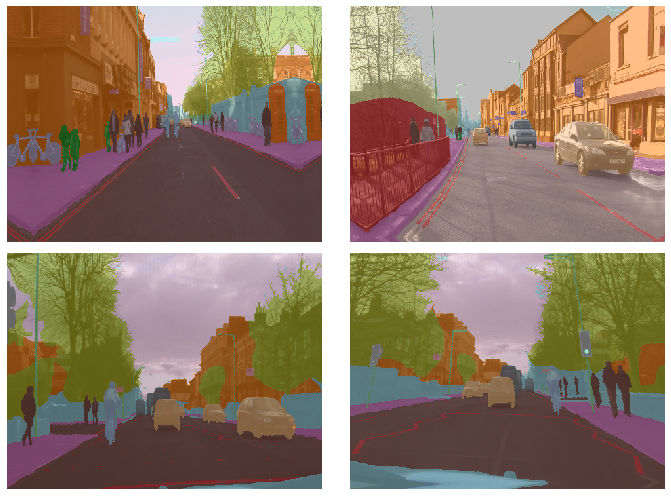

In [46]:
data.show_batch(2, figsize=(10,7))

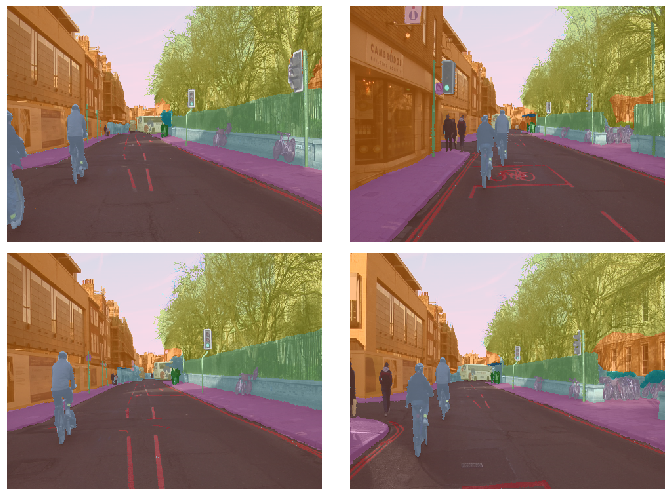

In [47]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

## Model

In [49]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [50]:
codes, name2id

(array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
        'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
        'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
        'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17'),
 {'Animal': 0,
  'Archway': 1,
  'Bicyclist': 2,
  'Bridge': 3,
  'Building': 4,
  'Car': 5,
  'CartLuggagePram': 6,
  'Child': 7,
  'Column_Pole': 8,
  'Fence': 9,
  'LaneMkgsDriv': 10,
  'LaneMkgsNonDriv': 11,
  'Misc_Text': 12,
  'MotorcycleScooter': 13,
  'OtherMoving': 14,
  'ParkingBlock': 15,
  'Pedestrian': 16,
  'Road': 17,
  'RoadShoulder': 18,
  'Sidewalk': 19,
  'SignSymbol': 20,
  'Sky': 21,
  'SUVPickupTruck': 22,
  'TrafficCone': 23,
  'TrafficLight': 24,
  'Train': 25,
  'Tree': 26,
  'Truck_Bus': 27,
  'Tunnel': 28,
  'V

In [51]:
metrics=acc_camvid
# metrics=accuracy

In [52]:
wd=1e-2

In [53]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


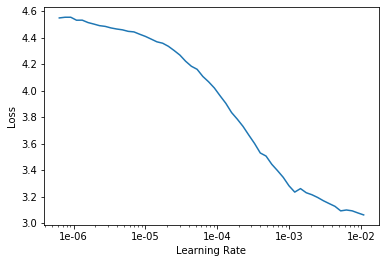

In [54]:
lr_find(learn)
learn.recorder.plot()

In [55]:
lr=3e-3

In [56]:
slice(lr)

slice(None, 0.003, None)

In [57]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.928894,0.621460,0.838237,01:38
1,0.746224,0.623551,0.841510,01:37
2,0.660925,0.534625,0.853842,01:38
3,0.615186,0.559231,0.854989,01:38
4,0.589959,0.457656,0.869720,01:37
5,0.603341,0.529817,0.874735,01:37
6,0.593295,0.456668,0.870418,01:36
7,0.531686,0.514067,0.865780,01:36
8,0.531979,0.443625,0.884569,01:35
9,0.423297,0.326176,0.907260,01:35


In [58]:
learn.save('stage-1')

In [59]:
learn.load('stage-1');

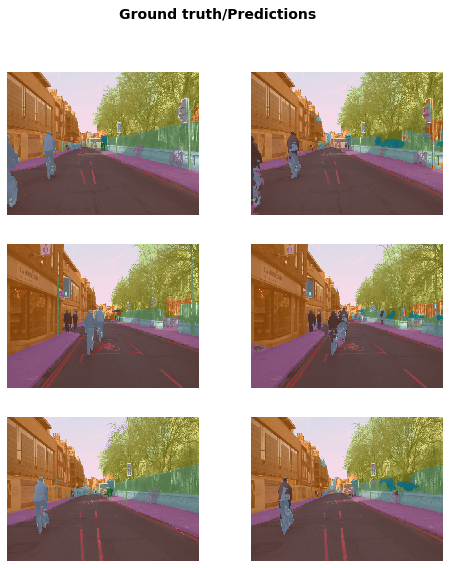

In [60]:
learn.show_results(rows=3, figsize=(8,9))

In [61]:
learn.unfreeze()

In [62]:
lrs = slice(lr/400,lr/4)

In [63]:
lrs

slice(7.5e-06, 0.00075, None)

In [64]:
learn.fit_one_cycle(12, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.376177,0.328802,0.904012,01:39
1,0.367978,0.321085,0.906409,01:41
2,0.359446,0.310921,0.909678,01:42
3,0.358034,0.305216,0.912409,01:41
4,0.354177,0.308047,0.909930,01:42
5,0.354427,0.323671,0.909789,01:42
6,0.356593,0.318899,0.912085,01:42
7,0.347971,0.299542,0.917954,01:42
8,0.331724,0.305182,0.911383,01:42
9,0.339819,0.309419,0.916660,01:42


In [65]:
learn.save('stage-2');

## Go big

You may have to restart your kernel and come back to this stage if you run out of memory, and may also need to decrease `bs`.

In [66]:
learn.destroy()

size = src_size

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=3
else:           bs=1
print(f"using bs={bs}, have {free}MB of GPU RAM free")

this Learner object self-destroyed - it still exists, but no longer usable
using bs=1, have 7104MB of GPU RAM free


In [67]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [68]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [69]:
learn.load('stage-2');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


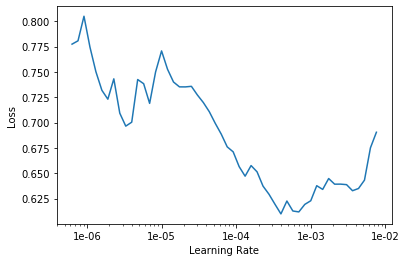

In [70]:
lr_find(learn)
learn.recorder.plot()

In [71]:
lr=1e-3

In [72]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.446276,0.357904,0.902225,06:40
1,0.414519,0.339123,0.906502,06:45
2,0.402741,0.312932,0.913554,06:45
3,0.372368,0.338716,0.912767,06:45
4,0.392878,0.375009,0.896414,06:45
5,0.396031,0.389798,0.891566,06:44
6,0.397784,0.325113,0.908812,06:44
7,0.347608,0.329640,0.911257,06:43
8,0.310584,0.311171,0.915824,06:43
9,0.267789,0.274492,0.925932,06:44


In [73]:
learn.save('stage-1-big')

In [74]:
learn.load('stage-1-big');

In [75]:
learn.unfreeze()

In [76]:
lrs = slice(1e-6,lr/10)

In [77]:
lrs

slice(1e-06, 0.0001, None)

In [78]:
learn.fit_one_cycle(10, lrs)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.231844,0.264945,0.928539,07:07
1,0.262011,0.284360,0.922124,07:07
2,0.274894,0.281305,0.921053,07:07
3,0.220773,0.292493,0.923138,07:07
4,0.251293,0.274053,0.926135,07:07
5,0.209125,0.284453,0.923334,07:07
6,0.219236,0.279095,0.924999,07:07
7,0.231265,0.283585,0.923675,07:07
8,0.212295,0.284741,0.922777,07:07
9,0.203036,0.282854,0.924116,07:08


In [79]:
learn.save('stage-2-big')

In [80]:
learn.load('stage-2-big');

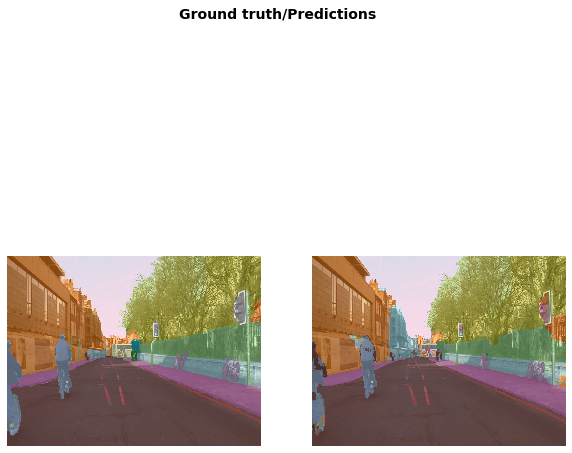

In [81]:
learn.show_results(rows=3, figsize=(10,10))

## fin